## Invariant potential CNF appraoch for learning $\phi^4$ theory

In [1]:
!nvidia-smi

Mon Sep  9 09:32:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|


|   0  Tesla T4                       Off | 00000000:00:07.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchdiffeq import odeint_adjoint as odeint

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available?  True


## Plotting Functions and ESS

In [3]:
from scipy.special import logsumexp

def effective_sample_size(logp, logq):
    logw = logp - logq
    log_ess = 2 * logsumexp(logw) - logsumexp(2 * logw)
    ess_per_sample = np.exp(log_ess) / logw.size
    return ess_per_sample


def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

In [4]:
def init_live_plot(figsize=(8, 4), logit_scale=True, **kwargs):
    fig, ax_ess = plt.subplots(1, 1, figsize=figsize, **kwargs)

    ess_line = plt.plot([0], [0.5], color='C0', label='ESS')
    plt.grid(False)
    plt.ylabel('ESS')
    if logit_scale:
        ax_ess.set_yscale('logit')
    else:
        plt.ylim(0, 1)

    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0], [1], color='C1', label='KL Loss')
    plt.grid(False)
    plt.ylabel('Loss')
    plt.xlabel('Steps')
    plt.legend(loc='upper right')

    lines = ess_line + loss_line
    plt.legend(lines, [line.get_label() for line in lines], loc='upper center', ncol=2)

    setup = dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line, logit=logit_scale)
    
    display_id = display(fig, display_id=True)
    setup['display_id'] = display_id

    return setup


def update_plots(history, setup, window_size=5):
    ess_line = setup['ess_line']
    loss_line = setup['loss_line']
    ax_loss = setup['ax_loss']
    ax_ess = setup['ax_ess']
    fig = setup['fig']

    ess = np.array(history['ess'])
    ess = moving_average(ess, window=window_size)
    steps = np.arange(len(ess))
    ess_line[0].set_ydata(ess)
    ess_line[0].set_xdata(steps)
    if setup['logit'] and len(ess) > 1:
        ax_ess.relim()
        ax_ess.autoscale_view()

    loss = np.array(history['loss'])
    loss = moving_average(loss, window=window_size)
    loss_line[0].set_ydata(loss)
    loss_line[0].set_xdata(steps)
    if len(loss) > 1:
        ax_loss.relim()
        ax_loss.autoscale_view()

    setup['display_id'].update(fig)

## Defining the CNF

We use the factorised standard unit normal distribution as prior

In [5]:
class GaussianPrior(torch.distributions.Distribution):

    arg_constraints = {}
    support = torch.distributions.constraints.real
    has_rsample = True

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def rsample(self, batch_size, N, dim):
        sample = torch.randn(batch_size, N, N, dim).to(device)
        # sample = F.normalize(sample)
        return sample

    def log_prob(self, z):
        shape = z.shape[-1]
        shape = (shape, shape)
        logp = -0.5 * (z**2 + torch.log(torch.tensor(2 * torch.pi)))
        logp = logp.sum(dim=(1,2,3))
        return logp
 
    def rsample_log_prob(self, batch_size, N, dim):
        z = self.rsample(batch_size, N, dim)
        return z, self.log_prob(z)

Define the invariant potential and equivariant vector model

In [6]:
"""# For preparing input into the model
def pairwise_elements(sample):

    N = sample.shape[1]

    rows = torch.arange(N)
    cols = torch.arange(N)
    up = (rows - 1) % N
    down = (rows + 1) % N
    left = (cols - 1) % N
    right = (cols + 1) % N

    # Gather neighbors
    gather_up = sample[:, up, :, :]         
    gather_down = sample[:, down, :, :]     
    gather_left = sample[:, :, left, :]     
    gather_right = sample[:, :, right, :]   

    # Compute dot products
    dot_up = (sample * gather_up).sum(dim=-1)  
    dot_down = (sample * gather_down).sum(dim=-1)  
    dot_left = (sample * gather_left).sum(dim=-1)  
    dot_right = (sample * gather_right).sum(dim=-1)  
    dot_self = (sample * sample).sum(dim=-1)  

    
    pairwise = torch.stack([dot_up, dot_right, dot_down, dot_left, dot_self], dim=-1) 
    neighbours = torch.stack([gather_up, gather_right, gather_down, gather_left, sample], dim=-2)

    return pairwise, neighbours"""

'# For preparing input into the model\ndef pairwise_elements(sample):\n\n    N = sample.shape[1]\n\n    rows = torch.arange(N)\n    cols = torch.arange(N)\n    up = (rows - 1) % N\n    down = (rows + 1) % N\n    left = (cols - 1) % N\n    right = (cols + 1) % N\n\n    # Gather neighbors\n    gather_up = sample[:, up, :, :]         \n    gather_down = sample[:, down, :, :]     \n    gather_left = sample[:, :, left, :]     \n    gather_right = sample[:, :, right, :]   \n\n    # Compute dot products\n    dot_up = (sample * gather_up).sum(dim=-1)  \n    dot_down = (sample * gather_down).sum(dim=-1)  \n    dot_left = (sample * gather_left).sum(dim=-1)  \n    dot_right = (sample * gather_right).sum(dim=-1)  \n    dot_self = (sample * sample).sum(dim=-1)  \n\n    \n    pairwise = torch.stack([dot_up, dot_right, dot_down, dot_left, dot_self], dim=-1) \n    neighbours = torch.stack([gather_up, gather_right, gather_down, gather_left, sample], dim=-2)\n\n    return pairwise, neighbours'

In [6]:
def pairwise_elements(sample):
    N = sample.shape[1]

    rows = torch.arange(N)
    cols = torch.arange(N)
    
    # Nearest neighbors 
    up = (rows - 1) % N
    down = (rows + 1) % N
    left = (cols - 1) % N
    right = (cols + 1) % N
    
    # Next-to-nearest neighbors 
    up_left_row = (rows - 1) % N
    up_left_col = (cols - 1) % N
    up_right_row = (rows - 1) % N
    up_right_col = (cols + 1) % N
    down_left_row = (rows + 1) % N
    down_left_col = (cols - 1) % N
    down_right_row = (rows + 1) % N
    down_right_col = (cols + 1) % N

    # Gather neighbors
    gather_up = sample[:, up, :, :]         
    gather_down = sample[:, down, :, :]     
    gather_left = sample[:, :, left, :]     
    gather_right = sample[:, :, right, :]   

    gather_up_left = sample[:, up_left_row, :, :][:, :, up_left_col, :]
    gather_up_right = sample[:, up_right_row, :, :][:, :, up_right_col, :]
    gather_down_left = sample[:, down_left_row, :, :][:, :, down_left_col, :]
    gather_down_right = sample[:, down_right_row, :, :][:, :, down_right_col, :]

    # Compute dot products
    dot_up = (sample * gather_up).sum(dim=-1)  
    dot_down = (sample * gather_down).sum(dim=-1)  
    dot_left = (sample * gather_left).sum(dim=-1)  
    dot_right = (sample * gather_right).sum(dim=-1)  
    dot_up_left = (sample * gather_up_left).sum(dim=-1)  
    dot_up_right = (sample * gather_up_right).sum(dim=-1)  
    dot_down_left = (sample * gather_down_left).sum(dim=-1)  
    dot_down_right = (sample * gather_down_right).sum(dim=-1)  
    dot_self = (sample * sample).sum(dim=-1)  

    # Stack pairwise dot products
    pairwise = torch.stack([dot_up, dot_up_right, dot_right, dot_down_right, dot_down,
                            dot_down_left, dot_left, dot_up_left, dot_self], dim=-1)

    # Stack neighbors
    neighbours = torch.stack([gather_up, gather_up_right, gather_right, gather_down_right, 
                              gather_down, gather_down_left, gather_left, gather_up_left, sample], dim=-2)

    return pairwise, neighbours

In [7]:
# construct equiv vec at point

class timedependence(nn.Module):
    def __init__(self, func):
        super(timedependence, self).__init__()
        self.func = func

    def forward(self, t, x):
        if not torch.is_tensor(t):
            t = torch.tensor(t).to(x.dtype)
        t_p = t.expand(x.shape[:-1] + (1,))
        return self.func(torch.cat((x, t_p), -1))

class equiv_vec2D_local(nn.Module):
    def __init__(self, N):
        super(equiv_vec2D_local, self).__init__()
        self.N = N
        self.neighbours = 9
        self.num_hidden_layers = 5
        self.hidden_features = 128


        layers = [
            nn.Linear(self.neighbours + 1, self.neighbours),
            nn.Tanh(),
            nn.Linear(self.neighbours, self.hidden_features),
            nn.Tanh(),
        ]

        # Add intermediate hidden layers in a loop
        for _ in range(self.num_hidden_layers - 2):  
            layers.extend([
                nn.Linear(self.hidden_features, self.hidden_features),
                nn.Tanh()
            ])

        # Append the final layer
        layers.append(nn.Linear(self.hidden_features, self.neighbours))

        # Wrap the layers in a Sequential container
        self.fc = timedependence(nn.Sequential(*layers))
    
    def forward(self, t, x):
        return self.fc(t, x)


class equiv_vec2D(nn.Module):
    def __init__(self, N, dim):
        super(equiv_vec2D, self).__init__()
        self.N = N
        self.dim = dim
        # self.neighbours = 5
        self.pairwise = pairwise_elements
        self.equivMLP = equiv_vec2D_local(N)

    def forward(self, t, x):
        pairwise, neighbours = self.pairwise(x)

        f_t = self.equivMLP(t, pairwise).unsqueeze(-1)
        out = (f_t * neighbours).sum(dim=-2)
        
        return out

In [8]:
def divergence_bf(dy, y):
    
    div = torch.zeros(y.shape).to(device)
    
    """for d in range(y.shape[-1]):
        div_d = torch.autograd.grad(dy[:, :, :, d].sum(), y, create_graph=True)[0].contiguous()
        div[:, :, :, d] += div_d[:, :, :, d]

    div = div.sum(dim=-1)"""

    div = torch.zeros(y.shape[0], y.shape[1], y.shape[2]).to(y.device)
    for i in range(y.shape[1]):
        for j in range(y.shape[2]):
            for d in range(y.shape[3]):
                div_d = torch.autograd.grad(dy[:, i, j, d].sum(), y, create_graph=True)[0].contiguous()
                div[:, i, j] += div_d[:, i, j, d]

    sum_diag = div.sum(dim=[1,2])
    return sum_diag.contiguous()

class ODEfunc(nn.Module):
    def __init__(self, diffeq):
        super(ODEfunc, self).__init__()

        self.diffeq = diffeq
        self.register_buffer("_num_evals", torch.tensor(0.))

    def before_odeint(self):
        self._num_evals.fill_(0)

    def num_evals(self):
        return self._num_evals.item()

    def forward(self, t, states):
        assert len(states) >= 2
        y = states[0]

        # increment num evals
        self._num_evals += 1

        # convert to tensor
        if not torch.is_tensor(t):
            t = torch.tensor(t).to(y)
        batchsize = y.shape[0]
        with torch.set_grad_enabled(True):
            y.requires_grad_(True)
            t.requires_grad_(True)
            dy = self.diffeq(t, y)
            divergence = divergence_bf(dy, y)

        return tuple([dy, -divergence])

Now define the CNF

In [9]:
class CNF(nn.Module):
    def __init__(self, N, dim):
        super(CNF, self).__init__()

        self.solver = 'rk4'
        self.atol = 1e-4
        self.rtol = 1e-4
        self.solver_options = {'step_size': 1/4}

        self.func = ODEfunc(equiv_vec2D(N, dim))
        self.prior = GaussianPrior()

    def forward(self, states):
        y_0 = states[0]
        log_p0 = states[1]
        time = torch.tensor([0, 1]).to(y_0).to(device)
        
        with torch.set_grad_enabled(True):
            #y_0.requires_grad_(True)
            #log_p0.requires_grad_(True)

            state_t = odeint(
                self.func,
                (y_0, log_p0),
                time,
                #rtol = self.rtol,
                #atol = self.atol,
                method = self.solver,
                options = self.solver_options
            )

            y_t, log_pt = state_t

        return y_t[-1], log_pt[-1]

    def get_regularization_states(self):
        return None

    def num_evals(self):
        return self.odefunc._num_evals.item()

Now define the $\phi^4$ theory class

In [10]:
from functools import partial

def phi4_action(phi, m2, lam):
    """ Compute the phi^4 action for a single or batched field configurations. """
    phis2 = phi ** 2
    # Potential energy term
    a = m2 * phis2 + lam * (phis2 ** 2)
    # Kinetic energy term
    a += sum((torch.roll(phi, 1, d) - phi) ** 2 for d in range(phi.ndim))
    return torch.sum(a)

class Phi4Theory():
    def __init__(self, shape, m2, lam):
        self.shape = shape
        self.m2 = m2
        self.lam = lam

    @property
    def lattice_size(self):
        return np.prod(self.shape)

    @property
    def dim(self):
        return len(self.shape)

    def action(self, phis, half=False):
        if phis.ndim == 2:
            action = phi4_action(phis, self.m2, self.lam) 
            return action /2 if half else action
        else:
            act = partial(phi4_action, m2=self.m2, lam=self.lam)
            action = torch.vmap(act)(phis)
            return action / 2 if half else action

## Training

Now define the reverse KL loss and the training loop

total_params:  52076
trainable_params:  52076
non_trainable_params:  0


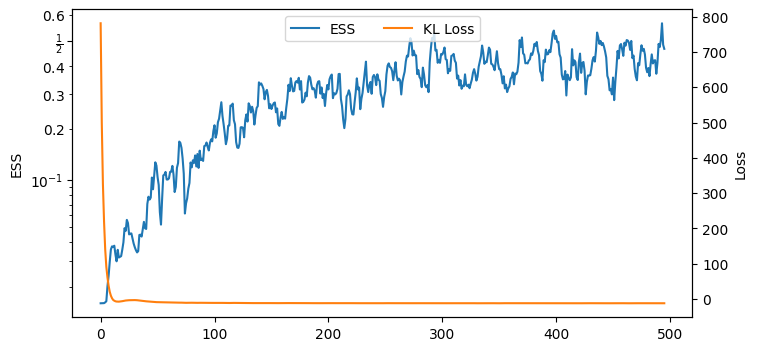

In [11]:
lattice_shape = (8,8)

dim = 1
m2 = -4  # mass squared
lam = 6.975  # phi^4 coupling
batch = 64


N = lattice_shape[0]
theory = Phi4Theory(shape=lattice_shape, m2=m2, lam=lam)
model = CNF(N=N, dim=dim).to(device)

def reverse_dkl(logp, logq):
    return torch.mean(logq - logp)

def loss_fn(model, theory):
        state = model.prior.rsample_log_prob(batch_size=batch, N=N, dim=dim)
        phi_t, logq = model.forward(state)
        logp = -theory.action(phi_t)
        dkl = reverse_dkl(logp, logq)
        return dkl, (logq, logp)

# For plotting
epochs = 50
epoch_size = 10

history = {
    'loss': [],
    'ess': [],
}

lr = 0.0005
weight_decay = 1e-5
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

lr_decay = 0.995
lr_step_size = 1
scheduler = optim.lr_scheduler.StepLR(opt, step_size = lr_step_size, gamma=lr_decay)

#num_drops = 2
#lr_milestones = [j*(epochs*epoch_size)//(num_drops+1) for j in range(1,num_drops+1)]
#scheduler = optim.lr_scheduler.MultiStepLR(opt, lr_milestones, gamma=.1)

total_params = 0
trainable_params = 0
for param in model.parameters():
    param_count = param.numel()
    total_params += param_count
    if param.requires_grad:
        trainable_params += param_count
print('total_params: ', total_params)
print('trainable_params: ', trainable_params)
print('non_trainable_params: ', total_params - trainable_params)

plot_config = init_live_plot()

model.train()
for era in range(epochs):

    ess_sum = 0
    counter = 0
    
    for epoch in range(epoch_size):
        opt.zero_grad()

        loss, (logq, logp) = loss_fn(model, theory)
        logp = logp.detach().cpu().numpy()
        logq = logq.detach().cpu().numpy()
        loss.backward()
        train_loss = loss.item()

        opt.step()
        ess = effective_sample_size(logp, logq)
        counter += 1
        ess_sum += ess
        # print(f'Epoch: {counter}, Avg ESS: {ess_sum/counter}')

        history['loss'].append(train_loss)
        history['ess'].append(ess)

    scheduler.step()
    update_plots(history, plot_config)

plt.close()

In [ ]:
loss_plot = []
ess_plot = []
lattice_shape = [(6,6),(8,8),(10,10),(12,12)]

dim = 1
m2 = -4  # mass squared
lam = 6.975  # phi^4 coupling
batch = 64

for i in lattice_shape:
    N = i[0]
    theory = Phi4Theory(shape=i, m2=m2, lam=lam)
    model = CNF(N=N, dim=dim).to(device)

    def reverse_dkl(logp, logq):
        return torch.mean(logq - logp)

    def loss_fn(model, theory):
            state = model.prior.rsample_log_prob(batch_size=batch, N=N, dim=dim)
            phi_t, logq = model.forward(state)
            logp = -theory.action(phi_t)
            dkl = reverse_dkl(logp, logq)
            return dkl, (logq, logp)

    # For plotting
    epochs = 50
    epoch_size = 10

    history = {
        'loss': [],
        'ess': [],
    }

    lr = 0.0005
    weight_decay = 1e-5
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    lr_decay = 0.995
    lr_step_size = 1
    scheduler = optim.lr_scheduler.StepLR(opt, step_size = lr_step_size, gamma=lr_decay)

    #num_drops = 2
    #lr_milestones = [j*(epochs*epoch_size)//(num_drops+1) for j in range(1,num_drops+1)]
    #scheduler = optim.lr_scheduler.MultiStepLR(opt, lr_milestones, gamma=.1)

    total_params = 0
    trainable_params = 0
    for param in model.parameters():
        param_count = param.numel()
        total_params += param_count
        if param.requires_grad:
            trainable_params += param_count
    print('total_params: ', total_params)
    print('trainable_params: ', trainable_params)
    print('non_trainable_params: ', total_params - trainable_params)

    plot_config = init_live_plot()

    model.train()
    for era in range(epochs):

        ess_sum = 0
        counter = 0
        
        for epoch in range(epoch_size):
            opt.zero_grad()

            loss, (logq, logp) = loss_fn(model, theory)
            logp = logp.detach().cpu().numpy()
            logq = logq.detach().cpu().numpy()
            loss.backward()
            train_loss = loss.item()

            opt.step()
            ess = effective_sample_size(logp, logq)
            counter += 1
            ess_sum += ess
            # print(f'Epoch: {counter}, Avg ESS: {ess_sum/counter}')

            history['loss'].append(train_loss)
            history['ess'].append(ess)

        scheduler.step()
        update_plots(history, plot_config)

    plt.close()

    loss_plot.append(history['loss'])
    ess_plot.append(history['ess'])

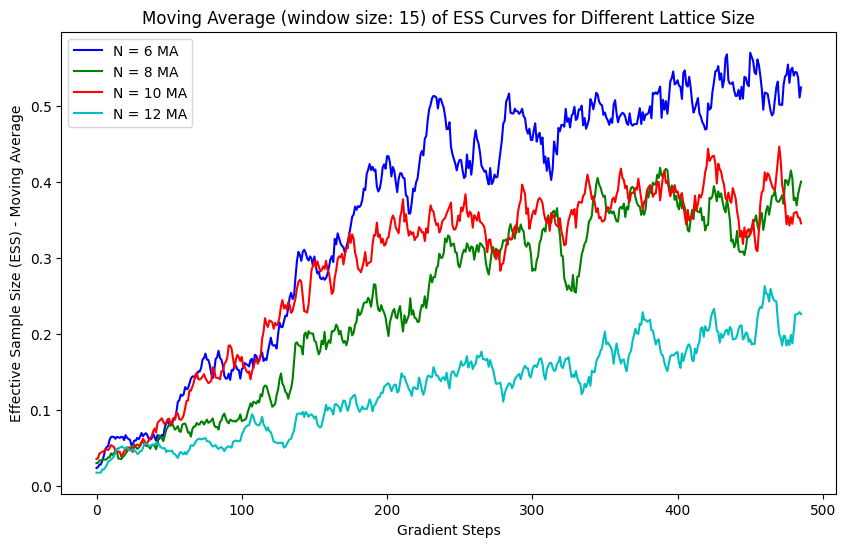

In [29]:
# Function to calculate the moving average of an array
def moving_average(data, window_size):
    # Compute the cumulative sum, and then take the difference to obtain the moving average
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size


# Function to calculate the standard deviation of the moving average
def moving_std(data, window_size):
    ma = moving_average(data, window_size)
    # Use list comprehension to calculate the standard deviation of each window
    stds = [np.std(data[i:i+window_size]) for i in range(len(data) - window_size + 1)]
    return np.array(stds)

# Labels for each curve
labels = ['N = 6', 'N = 8', 'N = 10', 'N = 12']
colors = ['b', 'g', 'r', 'c']  # Colors for each line
x = np.arange(500)  # Assuming 1000 gradient steps
window_size = 15  # Set the window size for the moving average

# Creating the plot
plt.figure(figsize=(10, 6))

# Plotting the moving average of each set of ESS data
for i, ess in enumerate(ess_plot):
    ma_ess = moving_average(ess, window_size)
    std_ess = moving_std(ess, window_size)
    x_adjusted = x[:len(ma_ess)]
    
    plt.plot(x_adjusted, ma_ess, label=f'{labels[i]} MA', color=colors[i])
    #plt.fill_between(x_adjusted, ma_ess - std_ess, ma_ess + std_ess, color=colors[i], alpha=0.2)

    #plt.plot(x[:1000 - window_size + 1], ma_ess, label=labels[i], color=colors[i])

# Adding labels and title
plt.xlabel('Gradient Steps')
plt.ylabel('Effective Sample Size (ESS) - Moving Average')
plt.title(f'Moving Average (window size: {window_size}) of ESS Curves for Different Lattice Size')
plt.legend()

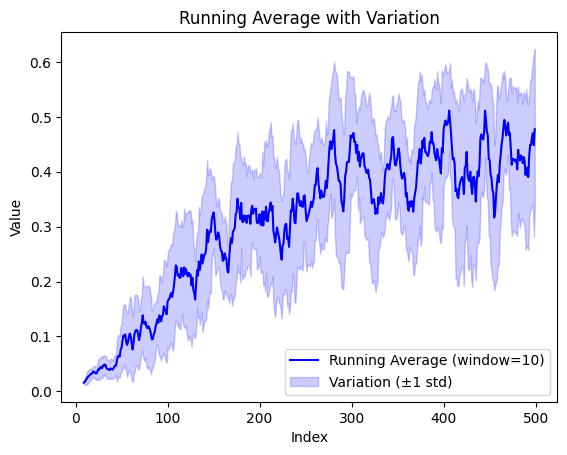

In [12]:
data = history['ess']

# Function to compute the running average
def running_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Function to compute the running standard deviation (for shading)
def running_std(data, window_size):
    stds = np.array([np.std(data[i:i+window_size]) for i in range(len(data) - window_size + 1)])
    return stds

# Set the window size
window_size = 10

# Calculate the running average
running_avg = running_average(data, window_size)

# Calculate the running standard deviation
running_std_dev = running_std(data, window_size)

# X values corresponding to the running average
x_values = np.arange(window_size-1, len(data))

# Plot the running average as a line curve
plt.plot(x_values, running_avg, label=f'Running Average (window={window_size})', color='blue')

# Plot the shaded region representing the standard deviation
plt.fill_between(x_values, running_avg - running_std_dev, running_avg + running_std_dev, color='blue', alpha=0.2, label='Variation (±1 std)')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Running Average with Variation')
plt.legend()

# Show the plot
plt.show()

In [13]:
with torch.no_grad():    
    prior_states = model.prior.rsample_log_prob(10,N,1)
    phis, logp = model.forward(prior_states)

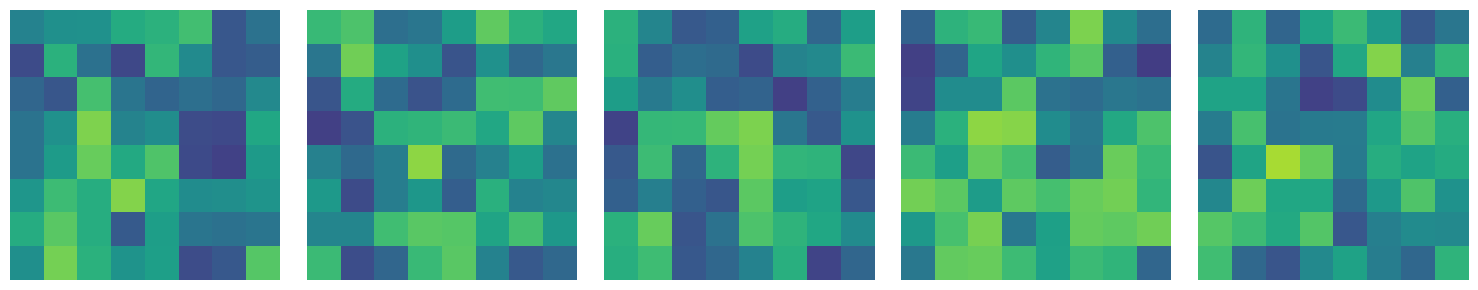

In [14]:
phis = phis.squeeze(1)
phis = phis.detach().cpu().numpy()
plt.figure(figsize=(15, 3))
for i in range(5):
    ax = plt.subplot(151 + i)
    plt.imshow(np.tanh(phis[i]), vmin=-1, vmax=1)
    ax.set_axis_off()

plt.tight_layout()

In [15]:
def serial_sample_generator(model, theory, batch_size, N_samples):
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            with torch.no_grad():
                prior_state = model.prior.rsample_log_prob(batch_size,N,1)
                x, logq = model.forward(prior_state)
                logp = -theory.action(x) 

                #logp = logp.detach().cpu().numpy()
                #x = x.detach().cpu().numpy()
                #logq = logq.detach().cpu().numpy()
                yield x[batch_i], logq[batch_i], logp[batch_i]

def make_mcmc_ensemble(model, theory, batch_size, N_samples, burn_in):

    burnin_history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    # burn-in
    burnin_gen = serial_sample_generator(model, theory, batch_size, burn_in)
    for new_x, new_logq, new_logp in burnin_gen:
        if len(burnin_history['logp']) == 0:
        # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = burnin_history['logp'][-1]
            last_logq = burnin_history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1).to(device) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = burnin_history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        burnin_history['logp'].append(new_logp)
        burnin_history['logq'].append(new_logq)
        burnin_history['x'].append(new_x)
        burnin_history['accepted'].append(accepted)

    history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    history['logp'].append(burnin_history['logp'][-1])
    history['logq'].append(burnin_history['logq'][-1])
    history['x'].append(burnin_history['x'][-1])
    history['accepted'].append(burnin_history['accepted'][-1])

    # build Markov chain
    sample_gen = serial_sample_generator(model, theory, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
        # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else:
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1).to(device) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history, sample_gen

In [16]:
ensemble_size = 10000
burnin = 1500
phi4_ens, sample = make_mcmc_ensemble(model, theory, 64, ensemble_size, burnin)
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.569620253164557


In [48]:
def cyclic_corr(arr1: torch.Tensor, arr2: torch.Tensor) -> torch.Tensor:
    # Implement the cyclic correlation as previously discussed.
    shape = arr1.shape
    dim = arr1.ndim
    
    c = torch.zeros_like(arr1)

    for shift in range(shape[1]):  # Adjust if other axes are involved
        shifted_arr2 = arr2.clone()

        for axis in range(1, dim-1):
            shifted_arr2 = torch.roll(shifted_arr2, shifts=shift, dims=axis)
        
        c += arr1 * shifted_arr2
    
    c /= torch.prod(torch.tensor(shape[1:-1]))

    return c

def two_point(phis: torch.Tensor, average: bool = True) -> torch.Tensor:
    """Estimate G(x) = <phi(0) phi(x)>."""
    # Apply cyclic_corr to each sample in the batch
    corr = torch.stack([cyclic_corr(phi, phi) for phi in phis])

    return torch.mean(corr, dim=0) if average else corr

def two_point_central(phis: torch.Tensor) -> torch.Tensor:
    """Estimate G_c(x) = <phi(0) phi(x)> - <phi(0)> <phi(x)>."""
    phis_mean = torch.mean(phis, dim=0)
    outer = phis_mean * torch.mean(phis_mean, dim=0, keepdim=True)
    
    return two_point(phis, True) - outer

In [49]:
two_point = two_point_central(phis)
plt.imshow(two_point.detach().cpu().numpy())

In [50]:
def correlation_length(G: torch.Tensor) -> torch.Tensor:

    Gs = torch.mean(G, dim=(0,2))
    arg = (torch.roll(Gs, 1, dims=0) + torch.roll(Gs, -1, dims=0)) / (2 * Gs)
    
    # Avoiding invalid values before applying arccosh
    arg = torch.clamp(arg, min=1.0)
    mp = torch.arccosh(arg[1:])
    
    return 1 / torch.nanmean(mp)

In [ ]:
# The drop off of the two point function is measured by the correlation length
corr_len = correlation_length(two_point)
# relative to the lattice size, this should be approximately 4 if the lambda chosen at the top was used
lattice_shape[0] / corr_len